IMPORT THE LIBRARIES

In [1]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

DATA CLEANING

In [2]:
#create a wrangle function for our dataset
def wrangle(filepath):
    #call the dataset 
    df = pd.read_csv(filepath)
    
    #format salary
    df[["lol","yr"]] =df["Salary"].str.split("/",expand=True)
    df["sal"]=df["lol"].str[1:]
    df["Annual Salary"] = df['sal'].str.replace(",","",regex=False)
   
    #mask string
    df = df[df["Annual Salary"] != 'FN 156179']
    
    #convert the salaries to int
    df["Annual Salary"] = df["Annual Salary"].astype(float)
    
    #create a log colum for salaries
    df["log_Salary"] = np.log(df["Annual Salary"])
    
    #remove the bottom 10% qunatiles and the top 90%
    low,high = df["Annual Salary"].quantile([0.1,0.9])
    mask_quantiles = df["Annual Salary"].between (low,high)
    df = df[mask_quantiles]
    
    #aggregate categorical variables
    top_3 = df["Job Title"].value_counts().head(3).index
    #aggregate using lambda function
    df["Job Title"]=df["Job Title"].apply(lambda c: c if c in top_3 else "Other")
    
    #remove the bottom 10% quantiles and the top 10% from salaries reported
    low,high = df["Salaries Reported"].quantile([0.1,0.9])
    mask_quantile = df["Salaries Reported"].between (low,high)
    df= df[mask_quantile]
    #delete high and low cardinality columns
    df.drop(columns=["Salary","lol","yr","sal","Annual Salary"],inplace=True)
    
    #drop null values
    df.dropna(inplace=True)
    #return the dataframe
    
    return df

USE THE WRANGLE FUNCTION

In [3]:
#use the wrangle function
df = wrangle(r"C:\Users\IFB19-039\Desktop\machine learning\Salary Dataset.csv")
df.head()

,Company Name,Job Title,Salaries Reported,Location,log_Salary
58,ABB,Data Scientist,6.0,Bangalore,13.769778
59,EY,Data Scientist,6.0,Bangalore,13.543017
61,Subex,Data Scientist,6.0,Bangalore,13.784135
62,iNeuron,Data Scientist,6.0,Bangalore,13.019176
63,ZS Associates,Data Scientist,6.0,Bangalore,14.107281


In [4]:
#print out the shape of the dataset
df.shape

(3154, 5)

In [5]:
#print out the summary statistics
df.describe()

,Salaries Reported,log_Salary
count,3154.000000,3154.000000
mean,1.791693,12.903119
std,1.233601,1.203814
min,1.000000,10.143174
25%,1.000000,12.443145
50%,1.000000,13.330923
75%,2.000000,13.815511
max,6.000000,14.318349


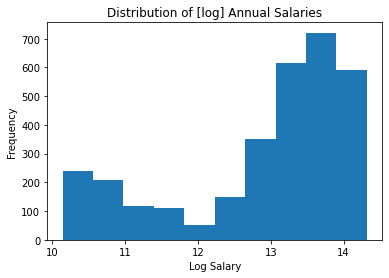

In [6]:
#plot a histogram for annual salary
plt.hist(df["log_Salary"])
plt.xlabel("Log Salary") #x axis label
plt.ylabel("Frequency") #y axis label
plt.title("Distribution of [log] Annual Salaries"); #title

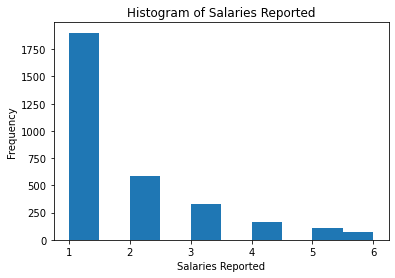

In [7]:
#plot a histogram for salaries reported
plt.hist(df["Salaries Reported"])
plt.title("Histogram of Salaries Reported") #title
plt.ylabel("Frequency") # define the y label
plt.xlabel("Salaries Reported"); # define the x label

RELATIONSHIP BETWEEN CATEGORICAL AND NUMERICAL DATA

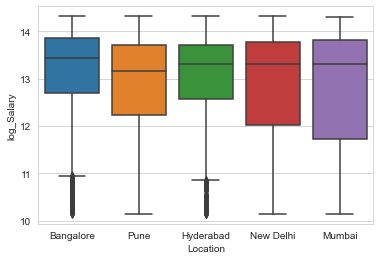

In [8]:
#is here a relationship between location and salaries reported
def plot_box(df, col, col_y = 'log_Salary'):
    sns.set_style("whitegrid")
    sns.boxplot(col, col_y, data=df)
    plt.xlabel(col) # Set text for the x axis
    plt.ylabel(col_y)# Set text for y axis
    plt.show()
    
plot_box(df, 'Location')    

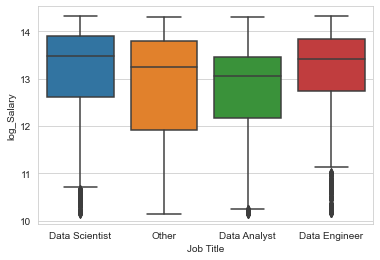

In [9]:
#is here a relationship between location and salaries reported
def plot_box(df, col, col_y = 'log_Salary'):
    sns.set_style("whitegrid")
    sns.boxplot(col, col_y, data=df)
    plt.xlabel(col) # Set text for the x axis
    plt.ylabel(col_y)# Set text for y axis
    plt.show()
    
plot_box(df, 'Job Title')    

In [10]:
df.head()

,Company Name,Job Title,Salaries Reported,Location,log_Salary
58,ABB,Data Scientist,6.0,Bangalore,13.769778
59,EY,Data Scientist,6.0,Bangalore,13.543017
61,Subex,Data Scientist,6.0,Bangalore,13.784135
62,iNeuron,Data Scientist,6.0,Bangalore,13.019176
63,ZS Associates,Data Scientist,6.0,Bangalore,14.107281


In [11]:
#relationship between salaries reported and salaries
p_correlation = df["Salaries Reported"].corr(df["log_Salary"])
p_correlation

0.08730980525839806

SPLIT THE DATA


In [12]:
target = "log_Salary"
features = ["Company Name","Job Title","Salaries Reported","Location"]
X_train = df[features]
y_train = df[target]
print("Shape of X_train:",X_train.shape)
print("Shape of y_train:",y_train.shape)


Shape of X_train: (3154, 4)
Shape of y_train: (3154,)


In [13]:
#get cutoff
cutoff = int(len(X_train)*0.8)
X_test = X_train.iloc[cutoff:]
y_test = y_train.iloc[cutoff:]

BUILD THE BASELINE FOR THE MODEL (NAIVE BAYES)

In [14]:
y_mean = y_train.mean()
print("Mean in Logs:",y_mean) # remember these values are log

#converting the log number to indian rupees
indian_rup = int(np.exp(y_mean))
print("Mean in Indian Rupees:",indian_rup)


Mean in Logs: 12.90311884612346
Mean in Indian Rupees: 401562


PRINT THE FIRST 5 PREDICTION

In [15]:
y_pred_baseline = [y_mean] * len(y_train)
#print the first 5 values
y_pred_baseline[:5]


[12.90311884612346,
 12.90311884612346,
 12.90311884612346,
 12.90311884612346,
 12.90311884612346]

TRAINING MAE

In [16]:
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))


Mean apt price 12.9
Baseline MAE: 0.97


BUILD A MODEL

In [17]:
model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        Ridge()
)
#fit the model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Company Name', 'Job Title', 'Location'],
                               use_cat_names=True)),
                ('ridge', Ridge())])

EVALUATE THE MODEL

In [18]:
training_mae = mean_absolute_error(y_train,model.predict(X_train))
test_mae = mean_absolute_error(y_test,model.predict(X_test))

print("TRAINING MAE:",training_mae)
print("TEST MAE:",test_mae)

TRAINING MAE: 0.6113643712008775
TEST MAE: 0.638164893243571


In [19]:
df.head()

,Company Name,Job Title,Salaries Reported,Location,log_Salary
58,ABB,Data Scientist,6.0,Bangalore,13.769778
59,EY,Data Scientist,6.0,Bangalore,13.543017
61,Subex,Data Scientist,6.0,Bangalore,13.784135
62,iNeuron,Data Scientist,6.0,Bangalore,13.019176
63,ZS Associates,Data Scientist,6.0,Bangalore,14.107281


In [31]:
def make_prediction(CompanyName,JobTitle,SalariesReported, Location):
    
    #create a dictionary
    data = {
        "Company Name":CompanyName,
        "Job Title":JobTitle,
        "Salaries Reported":SalariesReported,
        "Location":Location,    
    }
    #create a data frame from the dictionary
    df = pd.DataFrame(data,index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted Salaries: {prediction}"

DEPLOY THE MODEL

In [34]:
interact(
    make_prediction,
    SalariesReported=IntSlider(
        min=X_train["Salaries Reported"].min(),
        max=X_train["Salaries Reported"].max(),
        value=X_train["Salaries Reported"].mean(),
    ),   
    CompanyName = Dropdown(opions=sorted(X_train['Company Name'].unique())), 
    JobTitle = Dropdown(opions=sorted(X_train['Job Title'].unique())),
    Location = Dropdown(opions=sorted(X_train['Location'].unique())),
);

interactive(children=(Dropdown(description='CompanyName', options=(), value=None), Dropdown(description='JobTi…